In [1]:
import pdb
import time
import tqdm
import numpy as np
import pandas as pd
from collections import Counter

from hmmlearn.hmm import GaussianHMM

from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

# conda install -c omnia hmmlearn

# 0. Data
 - [Scenario10](https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-51/)
     - This scenario has multiple infected (67) and normal (471) IPs (with almost equivalent netflows)
     - Many IPs only have a few netflows unfortunately (check figure below)

 - Dataframe read. Pre-processing now... (9.45s)
 - Total len :  645358  (w/0 background and w/0 NaN)
 - label :  Counter({'Botnet': 323441, 'LEGITIMATE': 321917})
 - IPs   :  522
 - Label :  LEGITIMATE  || Unique IPs :  471
 - Label :  Botnet  || Unique IPs :  67


,datetime,duration,protocol,tos,packets,bytes,src_ip,src_port,dst_ip,dst_port,src_ip_num,dst_ip_num,protocol_num,flags_num,label
0,2011-08-18 10:19:13.347,4.985,TCP,0,91,86277,147.32.80.13,80,147.32.85.88,56949,0,0,0,0,LEGITIMATE
1,2011-08-18 10:19:13.392,0.000,TCP,0,1,66,147.32.86.110,48102,74.125.232.214,443,1,1,0,1,LEGITIMATE
2,2011-08-18 10:19:13.411,4.921,TCP,0,49,3234,147.32.85.88,56949,147.32.80.13,80,2,2,0,1,LEGITIMATE
3,2011-08-18 10:19:13.460,4.742,TCP,0,118,7080,147.32.84.59,2768,74.125.108.208,80,3,3,0,1,LEGITIMATE
4,2011-08-18 10:19:13.486,0.000,TCP,0,1,60,147.32.84.59,56058,74.125.232.215,443,3,4,0,1,LEGITIMATE


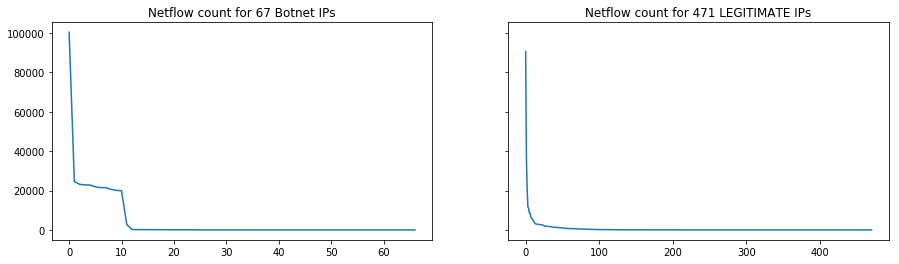

In [2]:
def getData(filename):
    t0 = time.time()
    if (1):
        cols = ['date', 'time', 'duration', 'protocol', 'src', 'direction', 'dst', 'flags', 'tos', 'packets', 'bytes', 'flows', 'label']
        df   = pd.read_csv(filename, skiprows=1, header=0, sep='\s+',names=cols)
    else:
        cols = ['date', 'time', 'duration', 'protocol', 'src', 'direction', 'dst', 'flags', 'tos', 'packets', 'bytes', 'flows', 'label', 'labels']
        df   = pd.read_csv(filename, skiprows=1, header=0, sep='\s+',names=cols)
    print (' - Dataframe read. Pre-processing now... ({0}s)'.format(round(time.time() - t0,2)))
    return df

def processData(df):
    # Step1 - Clean out NaN values
    df                           = df.fillna(0)
    
    # Step2 - Remove background labels
    df                           = df[df['label'] != 'Background']
    print (' - Total len : ', len(df), ' (w/0 background and w/0 NaN)')
    
    if (not df.isnull().values.any()):
        
        # Step3 - Index of Columns
        df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
        df             = df.set_index(df['datetime'])
        
        # Step4 - Column String Formatting
        df['src_ip'], df['src_port'] = df['src'].str.split(':', 1).str
        df['dst_ip'], df['dst_port'] = df['dst'].str.split(':', 1).str
        
        # Step5 - Codify columns
        df['src_ip_num']             = pd.Categorical(df['src_ip'], categories=df['src_ip'].unique()).codes
        df['dst_ip_num']             = pd.Categorical(df['dst_ip'], categories=df['dst_ip'].unique()).codes
        df['protocol_num']           = pd.Categorical(df['protocol'], categories=df['protocol'].unique()).codes
        df['flags_num']              = pd.Categorical(df['flags'], categories=df['flags'].unique()).codes
        
        # Step6 - Casting of columns
        df['packets'] = df['packets'].astype(int)
        df['bytes']  = df['bytes'].astype(int)
        
        # Stp7 - Drop Columns
        df.drop('src', axis=1, inplace=True)
        df.drop('dst', axis=1, inplace=True)
        df.drop('direction', axis=1, inplace=True)
        # df.drop('tos', axis=1, inplace=True)
        df.drop('flows', axis=1, inplace=True)
        df.drop('flags', axis=1, inplace=True)
        df.drop('date', axis=1, inplace=True)
        df.drop('time', axis=1, inplace=True)
        df.drop('datetime', axis=1, inplace=True)
        
        tmp = df.columns.tolist()
        tmp.remove('label')
        df  = df[tmp + ['label']]
        
        df.sort_index(inplace=True)
        df.reset_index(inplace=True)
        
        print (' - label : ', Counter(df['label']))
        print (' - IPs   : ', len(df['src_ip'].unique()))
        for label_ in df['label'].unique():
            unique_vals = df[df['label'] == label_]['src_ip'].unique()
            print (' - Label : ', label_, ' || Unique IPs : ', len(unique_vals))
        
    else:
        print (' - NAN detected!')
        
    return df

def plotHostDistribution(df_scene10):
    # Understanding the distribution of IPs
    f,axarr = plt.subplots(1,2, figsize=(15,4), sharey=True)
    if (1):
        df_scene10_infected       = df_scene10[df_scene10['label'] == 'Botnet']
        df_scene10_infected_count = df_scene10_infected.groupby('src_ip').aggregate({'protocol':'count'}).sort_values('protocol', ascending=False)
        df_scene10_infected_count_list = df_scene10_infected_count['protocol'].tolist()
        axarr[0].plot(df_scene10_infected_count_list)
        axarr[0].set_title('Netflow count for {0} Botnet IPs'.format(len(df_scene10_infected_count_list)))

    if (1):
        df_scene10_legitimate       = df_scene10[df_scene10['label'] == 'LEGITIMATE']
        df_scene10_legitimate_count = df_scene10_legitimate.groupby('src_ip').aggregate({'protocol':'count'}).sort_values('protocol', ascending=False)
        df_scene10_legitimate_count_list = df_scene10_legitimate_count['protocol'].tolist()
        axarr[1].plot(df_scene10_legitimate_count_list)
        axarr[1].set_title('Netflow count for {0} LEGITIMATE IPs'.format(len(df_scene10_legitimate_count_list)))
    
    plt.show()

if __name__ == "__main__":
    df_scene10_raw = getData('data/capture20110818.pcap.netflow.labeled')
    df_scene10     = processData(df_scene10_raw) 
    display(df_scene10.head(n=5))
    plotHostDistribution(df_scene10)

# 1. Task
 - a) Choose a probabilistic sequential model [Eg - HMMs]
 - b) Use a sliding window to obtain sequence data. 
 - c) Learn the chosen probabilistic sequential model from the data of one infected host
     - match its profile with all other hosts from the same scenario
 - d) Evaluate how many new infections your method finds and false positives it raises (as in paper 4)
 - e) Can you determine what behaviour your profile detects?

# 2.1 Discretization Routines
 - discretization of flow data as was done in Task3

In [3]:
class M_cat:

    def __init__(self, df, featname, verbose=0):
        self.s        = len(df[featname].unique())
        self.featname = featname
        self.df       = df
        if verbose:
            print (' - featname : ', featname, ' || Unique : ', df[featname].unique())
            print ('')
    
    def size(self): # return the size |M_i|
        return self.s

    def val(self, row): # return the value M_i
        return row[self.featname]

class M_num:

    def __init__(self, df, featname, verbose=0):
        self.bins            = 5
        self.percentiles     = list(range(100//self.bins, 100, 100//self.bins))
        self.percentiles[-1] = 100
        self.percentile_vals = np.percentile(df[featname].values, self.percentiles)
        self.s               = len(self.percentiles)
        self.featname        = featname
        self.df              = df
        if verbose:
            plt.plot(df[featname].values); plt.show()
            print (' - feat : ', featname, ' || percentiles :  ', self.percentiles)
            print (' - feat : ', featname, ' || percentile_vals : ', self.percentile_vals)
            print ('')

    def size(self): # return the size |M_i|
        return self.s

    def val(self, row): # return the value M_i
        val = row[self.featname]
        prev = 0
        for i, cur in enumerate(self.percentile_vals):
            if val >= prev and val < cur:
                return i
            prev = cur
        return 0
    
# encode a single flow
def encode_flow(feats, row, verbose=0):
    code       = 0
    space_size = 1
    for feat in feats:
        space_size *= feats[feat].size()
    for feat in feats:
        featObj = feats[feat]
        s = featObj.size()
        v = featObj.val(row)
        code += v * (space_size / s)
        space_size = space_size / s
        if verbose:
            print (' - feat : ',featObj.featname,' - row : ', row[featObj.featname], ' || v : ', v, ' || code : ', code)
    if verbose:
        print (' ---- code : ', code)
        pdb.set_trace()
        
    return code

# encode an entire series of flows
def encode_series(df, feats):
    encoded = []
    for index, row in df.iterrows():
        encoded.append(encode_flow(feats, row))
    return encoded

# 2.2 Prob Sequential Model - HMM-Train/Test/Evaluate Routines
 - Here, we use the HMM library - hmmlearn to model a test_ip sequence
 - We then compare its log-liklihood (or log probability) with other ips to determine their class
 - Ref : [Train HMM to infer hidden states](https://hmmlearn.readthedocs.io/en/latest/tutorial.html#training-hmm-parameters-and-inferring-the-hidden-states)

In [4]:
def createMapping(df_config, feats, verbose=0):
    feats_mapping = {}
    for feat in feats:
        if feat[1] == 'cat':
            feats_mapping[feat[0]] = M_cat(df_config, feat[0], verbose)
        if feat[1] == 'num':
            feats_mapping[feat[0]] = M_num(df_config, feat[0], verbose)
        if (verbose):
            print (' - [Train] feat : {0} || Size : {1}'.format(feat[0], feats_mapping[feat[0]].size()))
    
    return feats_mapping 

def trainHMM(df_train, feats_mapping, param_win, param_components, verbose=0):
        
    # Step1 - Turn discretized features into windowed data
    feats_discretized = encode_series(df_train,feats_mapping)
    if (1):
        size      = len(feats_discretized) - param_win
        data  = np.zeros((size,param_win),dtype=np.int32)
        for i in range(size):
            data[i] = np.array([flow for flow in feats_discretized[i:i+param_win]])
    
    # Step3 - Learn an HMM on the windowed data
    if (1):
        hmmObj = GaussianHMM(n_components=param_components)
        hmmObj.fit(data)
        hmmObj_ll_train, hmmObj_state_sequence = hmmObj.decode(data)
        if verbose : print (' - [Train] Log Likelihood : ', ll)
    
    return hmmObj, hmmObj_ll_train

def testHMM(df_test, hmmObj, feat_mapping, param_win, verbose):
    host_discrete = encode_series(df_test,feat_mapping)
    size          = len(host_discrete) - param_win
    
    log_likelihood = 0

    if size > 0:
        data = np.zeros((size,param_win),dtype=np.int32)
        for i in range(size):
            data[i] = np.array([flow for flow in host_discrete[i:i+param_win]])
        log_likelihood = hmmObj.decode(data)[0]

    if verbose:
        print (' - [test] ip : ', ip_test, ' || Log-Like : ', log_likelihood)
    
    return log_likelihood
    
def testHMMAll(df, hmmObj, ip_test_normal, ip_test_infected, feat_mapping, param_win, verbose=0):
    log_likelihoods = {}
    
    if (1):
        for ip_normal in ip_test_normal:
            log_likelihoods[ip_normal] = testHMM(df, hmmObj, ip_normal, feat_mapping, param_win, verbose)
    
        for ip_infected in ip_test_infected:
            log_likelihoods[ip_infected] = testHMM(df, hmmObj, ip_infected, feat_mapping, param_win, verbose)
    
    return log_likelihoods

def evaluateHMM(log_likelihoods, hmmObj_ll_train, ip_infected, ip_normal, verbose=0):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    positives = []
    negatives = []

    # 
    dist = {}
    for ip in log_likelihoods.keys():
        # absolute log-likelihood distance
        dist[ip] = abs(log_likelihoods[ip] - hmmObj_ll_train)
        # threshold is half log-likelihood
        if dist[ip] > hmmObj_ll_train / 2:
            negatives.append(ip)
        else:
            positives.append(ip)
    
    if verbose:
        print (' - infected : ', positives)
        print (' - normal   : ', negatives)

    # evaluate all potentially malicious hosts
    for i in positives:
        if i in ip_infected:
            TP += 1
        else:
            FP += 1

    # evaluate all potentially benign hosts
    for i in negatives:
        if i in ip_normal:
            TN += 1
        else:
            FN += 1
    
    return TP, FP, TN, FN    

# 3.1 Task - BotNet Profiling (Single Scene Scenario)
 - Here, we split the dataset into configuration, train and validation as was done in [Paper4](https://ieeexplore.ieee.org/document/7987293/)
 - We then pick the same TRAIN_IP and top 380 IPs (by netflow count) for the validation dataset
 - Each of these IPs has its log-likelihood value calculated and compared against the TRAIN_IP log-likelihood
 - Some of the IPs are discarded due to them having netflows lesser than that of the windowing parameter 

In [5]:
def getSplitData(df, IP_TRAIN, verbose=0):
    
    # Step0 - Select top 380 hosts (as per paper)
    df_tmp = df_scene10.groupby('src_ip').aggregate({'protocol':'count'}).sort_values('protocol', ascending=False).head(n=380)
    
    # Step1 - Split dataset into configuration, train, validation
    df_config = df[df['label'] == 'LEGITIMATE'].sample(frac=0.3,  random_state=42)
    df_train  = df[df['src_ip'] == IP_TRAIN] 
    df_valid  = df[~df.index.isin(df_config.index)]
    df_valid  = df_valid[df_valid['src_ip'] != IP_TRAIN] 
    
    top_380_ips = df_valid.groupby('src_ip').aggregate({'protocol':'count'}).sort_values('protocol', ascending=False).head(n=380).index
    df_valid   = df_valid[df_valid['src_ip'].isin(top_380_ips)] 
    
    if verbose:
        print ('- Step 0 : Prepare datasets ...')
        print (' - [DATA] Total  : ', len(df))
        print (' - [DATA] Config : ', len(df_config))
        print (' - [DATA] Train  : ', len(df_train))
        print (' - [DATA] Valid  : ', len(df_valid))

    df_valid_botnet = df_valid[df_valid['label'] == 'Botnet']
    df_valid_legit  = df_valid[df_valid['label'] == 'LEGITIMATE']
    df_valid_botnet_ips = df_valid_botnet['src_ip'].unique()
    df_valid_legit_ips  = df_valid_legit['src_ip'].unique()
        
    if verbose:
        print (' - [DATA] Valid (Botnet flows) : ', len(df_valid_botnet))
        print (' - [DATA] Valid (Legit flows)  : ', len(df_valid_legit))
        print (' - [DATA] Valid (Botnet IPs)   : ', len(df_valid_botnet_ips) - 1)
        print (' - [DATA] Valid (Legit IPs)    : ', len(df_valid_legit_ips))
    
    return df_config, df_train, df_valid, df_valid_botnet, df_valid_legit, df_valid_botnet_ips, df_valid_legit_ips
 
def eval_netflows(df_valid, df_valid_botnet, df_valid_legit, df_valid_botnet_ips, df_valid_legit_ips
         , param_winsize, param_HMM_states
         , feats_mapping, hmmObj, hmmObj_ll_train, IP_TRAIN
         ,verbose=0):
    
    
    if (1):
        res          = []
        df_valid_ips = df_valid['src_ip'].unique()
        with tqdm.tqdm_notebook(total = len(df_valid_ips)) as pbar:
            for valid_ip in df_valid_ips:
                pbar.update(1)
                df_valid_tmp        = df_valid[df_valid['src_ip'] == valid_ip]
                df_valid_tmp_labels = df_valid_tmp['label'] 
                df_valid_tmp_label  = df_valid_tmp_labels.unique()
                if (len(df_valid_tmp_label) == 1):
                    if len(df_valid_tmp) >= param_winsize:
                        botnet_ll = testHMM(df_valid_tmp, hmmObj, feats_mapping, param_winsize, 0)
                        res.append([valid_ip, len(df_valid_tmp), df_valid_tmp_label[0], botnet_ll, hmmObj_ll_train])
    
    if (1):
        df_res = pd.DataFrame(res, columns=['Botnet IP', 'Netflows', 'Class', 'Test LL', 'Train LL'])
        df_res_botnet = df_res[df_res['Class'] == 'Botnet']
        df_res_legit  = df_res[df_res['Class'] == 'LEGITIMATE'] 
        print (len(df_res), len(df_res_botnet), len(df_res_legit))
    
    if (1):
        TP = len(df_res_botnet[df_res_botnet['Test LL'] > 0])
        FN = len(df_res_botnet[df_res_botnet['Test LL'] <= 0])
        TN = len(df_res_legit[df_res_legit['Test LL'] <= 0])
        FP = len(df_res_legit[df_res_legit['Test LL'] > 0])
        precision = TP / (TP + FP)
        recall    = TP / (TP + FN)
        f1        = 2*precision*recall / (precision + recall)

        conf_mat = [[TN, FP], [FN, TP]]
        print ('')
        
        print (' - Conf Mat')
        print (np.array(conf_mat))
        print (' - Precision  : ', round(precision,3), ' || - Recall : ', round(recall,2), ' || F1 - ', round(f1,2))
        print (' - Botnet IPs : ', len(df_res_botnet), ' || - Legit IPs : ', len(df_res_legit))        
        print (' -------------------------- ( WinSize : {0} || HMM-States : {1}) -------------------------- '.format(param_winsize, param_HMM_states))
    
    return df_res_botnet, df_res_legit

In [6]:
if __name__ == "__main__":
    
    # Step0 - Split dataset into configuration, train, validation
    if (1):
        IP_TRAIN = '147.32.84.165' #from paper since it has 19889 netflows
        df_config, df_train, df_valid, df_valid_botnet, df_valid_legit , df_valid_botnet_ips, df_valid_legit_ips = getSplitData(df_scene10, IP_TRAIN, verbose=1)
    
    # Step1 - Create Mapping
    if (1):
        print ('')
        print (' - Step1 - Creating mapping ...')
        feats         = [('protocol_num','cat'), ('bytes','num')]
        feats_mapping = createMapping(df_config, feats)
    
    # Step2 - Grid Search of Params
    if (1):
        
        param_winsizes        = [3]
        param_HMM_states_list = [2]
        verbose               = 1
        
        for param_winsize in param_winsizes:
            for param_HMM_states in param_HMM_states_list: 
                print ('')
                print (' -------------------------- ( WinSize : {0} || HMM-States : {1}) -------------------------- '.format(param_winsize, param_HMM_states))
                
                # Step1 - Train
                if (1):
                    if verbose : print (' - Step2 - Training ....')
                    hmmObj, hmmObj_ll_train = trainHMM(df_train, feats_mapping, param_winsize, param_HMM_states)

                # Step2 - Valid
                if (1):
                    df_res_botnet, df_res_legit = eval_netflows(df_valid, df_valid_botnet, df_valid_legit, df_valid_botnet_ips, df_valid_legit_ips
                                     , param_winsize, param_HMM_states, feats_mapping, hmmObj, hmmObj_ll_train, IP_TRAIN
                                     ,verbose=verbose)

- Step 0 : Prepare datasets ...
 - [DATA] Total  :  645358
 - [DATA] Config :  96575
 - [DATA] Train  :  19889
 - [DATA] Valid  :  528717
 - [DATA] Valid (Botnet flows) :  303527
 - [DATA] Valid (Legit flows)  :  225190
 - [DATA] Valid (Botnet IPs)   :  44
 - [DATA] Valid (Legit IPs)    :  351

 - Step1 - Creating mapping ...

 -------------------------- ( WinSize : 3 || HMM-States : 2) -------------------------- 
 - Step2 - Training ....


/home/strider/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


254/|/ 67%|| 254/380 [01:13<00:04, 28.64it/s]
350 28 322

 - Conf Mat
[[322   0]
 [ 18  10]]
 - Precision  :  1.0  || - Recall :  0.36  || F1 -  0.53
 - Botnet IPs :  28  || - Legit IPs :  322
 -------------------------- ( WinSize : 3 || HMM-States : 2) -------------------------- 


# 3.2 - What behavior did we detect?
 - After a sequential modelling, we analyze the behaviours of the different classes of IPs
 - Lookout for the HMM states plot which clearly shows the difference in hidden state predictions for Botnet vs LEGITIMATE IPs
 - You can choose more IPs to study using the dataframes at the end (the names are self-explanatory)

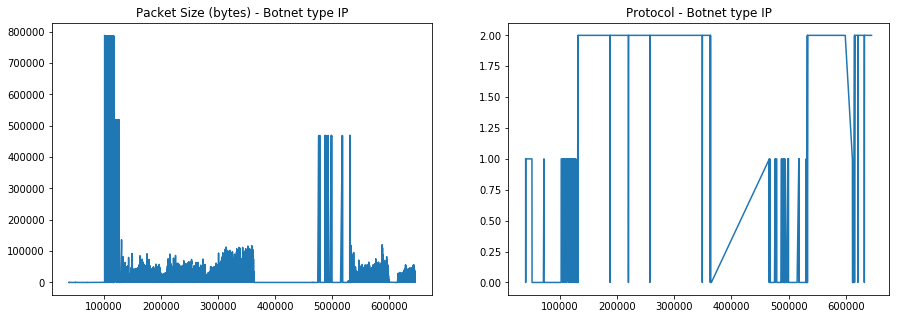

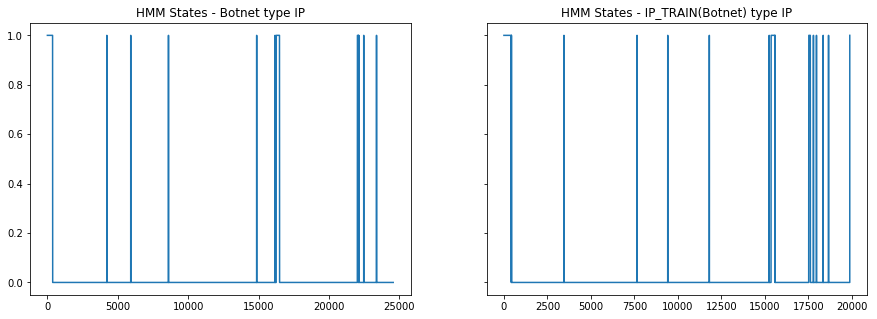


 ----------------------------------  


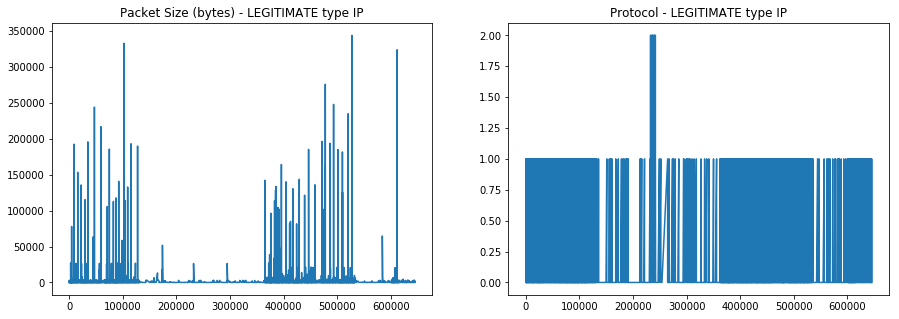

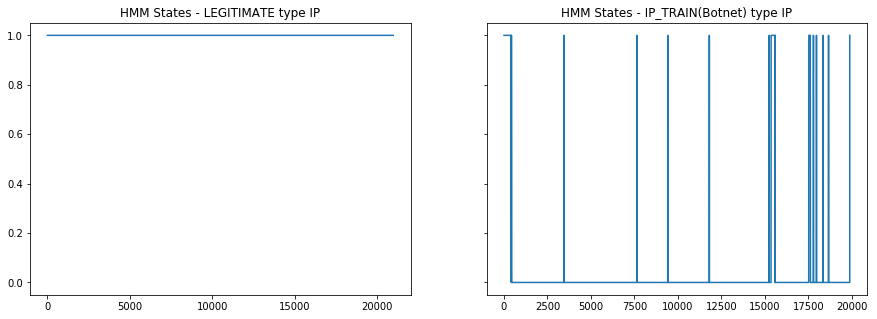


 ----------------------------------  


In [7]:
def study_behaviour(df, IP_TRAIN, ip_study, ip_type, hmmObj, feats_mappings, param_win):
    tmp_df_ip    = df[df['src_ip'] == ip_study]
    tmp_df_train = df[df['src_ip'] == IP_TRAIN]
    
    if (1):
        f,axarr = plt.subplots(1,2, figsize=(15,5))
        axarr[0].plot(tmp_df_ip['bytes']); 
        axarr[0].set_title('Packet Size (bytes) - {0} type IP'.format(ip_type));
        axarr[1].plot(tmp_df_ip['protocol_num']); 
        axarr[1].set_title('Protocol - {0} type IP'.format(ip_type));
        plt.show()
        
    if (1):
        f,axarr = plt.subplots(1,2, figsize=(15,5), sharey=True)
        
        feats_discretized = encode_series(tmp_df_ip,feats_mapping)
        size      = len(feats_discretized) - param_win
        data  = np.zeros((size,param_win),dtype=np.int32)
        for i in range(size):
            data[i] = np.array([flow for flow in feats_discretized[i:i+param_win]])
        hmmObj_ll_train, hmmObj_state_sequence = hmmObj.decode(data)
        axarr[0].plot(hmmObj_state_sequence)
        axarr[0].set_title('HMM States - {0} type IP'.format(ip_type))
        
        feats_discretized = encode_series(tmp_df_train,feats_mapping)
        size      = len(feats_discretized) - param_win
        data  = np.zeros((size,param_win),dtype=np.int32)
        for i in range(size):
            data[i] = np.array([flow for flow in feats_discretized[i:i+param_win]])
        hmmObj_ll_train, hmmObj_state_sequence = hmmObj.decode(data)
        axarr[1].plot(hmmObj_state_sequence);
        axarr[1].set_title('HMM States - {0} type IP'.format('IP_TRAIN(Botnet)'))
        plt.show()
        print ('')
        print (' ----------------------------------  ')
        
if __name__ == "__main__":
    study_behaviour(df_scene10, IP_TRAIN, '147.32.84.205', 'Botnet'    , hmmObj, feats_mapping, param_winsize)
    study_behaviour(df_scene10, IP_TRAIN, '147.32.84.170', 'LEGITIMATE', hmmObj, feats_mapping, param_winsize)
    

In [11]:
df_res_legit.sort_values('Netflows')
df_res_botnet.sort_values('Netflows')

,Botnet IP,Netflows,Class,Test LL,Train LL
335,41.208.134.212,4,Botnet,-6.790069e+00,355393.601844
179,195.113.232.90,4,Botnet,-6.606816e+00,355393.601844
160,195.113.232.75,6,Botnet,-1.985943e+01,355393.601844
343,174.143.119.91,11,Botnet,-5.457735e+01,355393.601844
345,130.239.18.172,17,Botnet,-1.014581e+02,355393.601844
307,211.95.79.224,43,Botnet,-2.729608e+02,355393.601844
167,93.152.160.101,53,Botnet,-3.424418e+02,355393.601844
304,216.155.130.130,57,Botnet,-3.734535e+02,355393.601844
295,213.92.8.4,61,Botnet,-3.982000e+02,355393.601844
126,147.32.96.45,71,Botnet,-5.026670e+02,355393.601844
